#### 라이브러리 불러오기

In [1]:
import os
import re
import platform

import numpy as np
import pandas as pd
import tensorflow as tf
from datetime import datetime

from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
import lightgbm as lgb

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

2023-08-26 22:46:14.094621: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### 설정

In [2]:
SEED = 1234

##### 차트 한글설정

In [3]:
import matplotlib.font_manager as fm
import platform

os_name = platform.system()

# font_path는 사용할 폰트에 따라 변경하면 됨
font_path = 'c:/Windows/Fonts/malgun.ttf' if os_name=='Windows' \
    else '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_family = fm.FontProperties(fname=font_path).get_name()

# font 설정
plt.rcParams['font.family'] = font_family

In [4]:
# 폰트캐시까지 삭제 후 한글폰트가 사용될 수 있도록 캐시 삭제
# --> 이렇게 해야 비로소 한글이 표현되는 경우가 많음
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = [font_family]

fe = fm.FontEntry(
    fname='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    name='NanumGothic'
)
fm.fontManager.ttflist.insert(0, fe)

#### 모델 평가함수 생성

In [5]:
def user_mape(test_y, pred_y):
    # 예측대상(test_y)값이 0인 경우를 대비해, 
    # 0이 아닌 아주 작은수를 더해 MAPE값을 구함
    epsilon = 1e-10
    
    abs_err = np.abs(test_y - pred_y)
    test_y = test_y + epsilon

    p_err = np.where(abs_err==0, 0, abs_err / test_y * 100)
    # 음수 값이면 양수로 변경
    p_err = np.where(p_err<0, -p_err, p_err)
    # 100보다 큰 값은 100으로 제한
    p_err = np.minimum(p_err, 100)
    # MAPE의 평균 반환
    return np.mean(p_err)

def evaluation_func(test_y, pred_y, verbose=1):
    # 모든값을 소숫점 5자리에서 반올림
    _test_y = np.round(test_y, decimals=5)
    _pred_y = np.round(pred_y, decimals=5)
    
    mse = mean_squared_error(_test_y, _pred_y)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(_test_y, _pred_y)
    r2score = r2_score(_test_y, _pred_y)
    mape = mean_absolute_percentage_error(_test_y, _pred_y)
    mape2 = user_mape(_test_y, _pred_y)
    
    if verbose != 0:
        print(
            f'R2_SCORE: {r2score:.6f}, MAPE2: {mape2:.6f}, '
            f'MSE: {mse:.6f}, RMSE: {rmse:.6f}, '
            f'MAPE: {mape:.6f}, MAE: {mae:.6f}'
        )
        
    return mse, rmse, mae, mape, mape2

#### 데이터 불러오기

In [6]:
PATH_DATA = os.path.join(os.getcwd(), 'data', '32-car-accident')
PATH_ACCIDENT = os.path.join(PATH_DATA, 'train_accident_2013_2017.csv') 
PATH_WEATHER = os.path.join(PATH_DATA, 'train_weather_2013_2017.csv')
# 테스트데이터는 자전거대여 관련 데이터이기 때문에 제거
# PATH_TEST = os.path.join(PATH_DATA, 'test.csv')

df_a = pd.read_csv(PATH_ACCIDENT)
df_w = pd.read_csv(PATH_WEATHER)
# 테스트데이터는 자전거대여 관련 데이터이기 때문에 제거
# df_test = pd.read_csv(PATH_TEST)

In [7]:
print(
    f'ACCIDENT: {df_a.발생날짜.min()} ~ {df_a.발생날짜.max()}, cnt: {df_a.shape[0]:>4}\n'
    f' WEATHER: {df_w.tm.min()} ~ {df_w.tm.max()}, {df_w.shape[0]:>9}'
    # f'   test: {test_df.tm.min()} ~ {test_df.tm.max()}, {test_df.shape[0]:>9}'
)
# ACCIDENT 데이터가 실제 데이터와 차이가 있네?
# 2013년 1월 3일 목요일 ~ 2017년 12월 29일 금요일

ACCIDENT: 2013년 10월 10일 목요일 ~ 2017년 9월 9일 토요일, cnt: 1143
 WEATHER: 2013-01-01 ~ 2017-12-31,      1826


#### 데이터전처리

##### 날짜형 인덱스 생성

In [8]:
# '2013년 1월 3일 목요일' 형식은 날짜형식의 정규식을 만들기 어렵기 때문에
# 별도 변환 함수 생성
def to_datetime_accident(row):
    nums = re.findall(r'\d+', row['발생날짜'])
    dt_str = f'{nums[0]}-{int(nums[1]):02}-{int(nums[2]):02}'
    return pd.to_datetime(dt_str)

df_a['발생날짜'] = df_a.apply(to_datetime_accident, axis=1)
df_w.tm = pd.to_datetime(df_w.tm)


In [9]:
df_a = df_a.set_index('발생날짜')
df_w = df_w.set_index('tm')

##### 무사고 날자에 로우 추가(값은 0)

In [10]:
# 사고발생 데이터에는 사고가 발생한 날자만 들어있기 때문에,
# 사고가 발생하지 않는 날의 데이터 추가해 줘야함
# 대상 기간의 기상 데이터의 시작과 끝 날짜로 함.

In [11]:
# 기상데이터의 시작일과 종료일을 기준으로 데이터 추가 구간 설정
date_range = pd.date_range(start=df_w.index.min(), end=df_w.index.max())

# 기존 데이터프레임에 있는 날자 제거
missing_dates = set(date_range) - set(df_a.index)

# 데이터(0) 추가
for _date in missing_dates:
    df_a.loc[_date] = 0
    
df_a = df_a.sort_index()

##### 훈련용 데이터 결합

In [12]:
# 사고데이터는 기상데이터의 시작과 끝 모든 데이터를 가지고 있기 때문에,
# 사고데이터 >= 기상데이터가 되니 결합방향은 기상데이터쪽으로 진행
df_train = pd.merge(df_w, df_a, left_index=True, right_index=True, how='inner')

##### 고유값 갯 수가 1인 컬럼 제거

In [13]:
# 고유값 갯 수가 1인 컬럼은 모델훈련에 영향을 주지 않음
n_unique_values = df_train.nunique()
print(f'고유값 갯 수가 1인 컬럼: {n_unique_values[n_unique_values==1].index}')

고유값 갯 수가 1인 컬럼: Index(['stnId', 'stnNm'], dtype='object')


In [14]:
# 고유값 갯 수 1인 컬럼과 기존 인덱스 컬럼 삭제
drop_cols_uv1 = df_train.columns[n_unique_values==1]
drop_cols_uv1 = drop_cols_uv1.union(['Unnamed: 0'])
df_train.drop(columns=drop_cols_uv1, axis=1, inplace=True)

##### 결측치 처리

In [15]:
df_train.isna().sum().sort_values(ascending=False)[:20]

sumFogDur         1799
ddMefsHrmt        1764
sumDpthFhsc       1762
ddMefs            1762
ddMes             1702
ddMesHrmt         1702
mi10MaxRnHrmt     1514
hr1MaxRnHrmt      1510
mi10MaxRn         1399
hr1MaxRn          1399
n99Rn             1127
sumRn             1123
sumRnDur          1123
sumLrgEv           547
iscs               501
avgLmac             21
avgCm30Te           21
sumGsr              18
hr1MaxIcsr          17
hr1MaxIcsrHrmt      17
dtype: int64

> 사고발생 관점에서 다 중요한 데이터인데 NaN값이 99% 이상이네;;
* sumFogDur: 안개 지속 시간의 합계
* ddMefsHrmt: 안개 형태의 관측 시각
* sumDpthFhsc: 안개의 깊이 누적 합계
* ddMefs: 안개 형태
* ddMes: 안개 종류
* ddMesHrmt: 안개 종류의 관측 시각
* mi10MaxRnHrmt: 10분 강수량 최대치의 관측 시각
* hr1MaxRnHrmt: 1시간 강수량 최대치의 관측 시각
* mi10MaxRn: 10분 강수량 최대치
* hr1MaxRn: 1시간 강수량 최대치
* n99Rn: 99분 동안 강수량
* sumRn: 강수량 합계
* sumRnDur: 강수 지속 시간 합계
* sumLrgEv: 대형증발량 합계
* iscs: 풍무 형태

In [16]:
fill_0_cols = [
    'sumFogDur', 'ddMefsHrmt', 'sumDpthFhsc', 'ddMefs', 'ddMes',
    'ddMesHrmt', 'mi10MaxRnHrmt', 'hr1MaxRnHrmt', 'mi10MaxRn',
    'hr1MaxRn', 'n99Rn', 'sumRn', 'sumRnDur', 'sumLrgEv'
]
def fill_nan(column):
    # 문자열 컬럼
    if column.name == 'iscs':
        return column.fillna('')
    # 너무 많은 결측치가 있는 데이터는 0으로
    elif column.name in fill_0_cols:
        return column.fillna(0)
    # 적당하거나 적은 결측치는 시계열값을 반영한 중앙값으로
    return column.interpolate()

In [17]:
df_train = df_train.apply(fill_nan)

In [18]:
df_train.isna().sum().sort_values(ascending=False)

avgTa             0
ssDur             0
hr1MaxIcsrHrmt    0
hr1MaxIcsr        0
sumGsr            0
                 ..
avgPa             0
maxPs             0
maxPsHrmt         0
minPs             0
사망자수              0
Length: 61, dtype: int64

* '{박무}0210-{박무}{강도0}0300-{박무}{강도0}0600-{박무}{강도0}0900-{박무}{강도0}1200-1425.'
* '-{비}-{비}{강도0}0300-{비}{강도0}0600-{안개비}0830-{안개비}{강도0}0900-0950.'
* '{눈}0455-{눈}{강도0}0600-{시정(미만)}{1km}{눈}0620-{시정(이상)}{1km}{눈}0740-0820. {눈}1045-{눈}{강도0}1200-1210. {눈}1940-{시정(미만)}{1km}{눈}2050-{눈}{강도1}2100-{시정(이상)}{1km}{눈}2110-2346.'
* 이런 식으로 저장된 `iscs`컬럼을 어떻게 사용할 지 고민(시간과 기상상태를 나타내는 중요한 정보인데;;)

##### 속성과 예측값 분류

In [19]:
def get_season(month):
    return 0 if 3<=month<=5 else 1 if 6<=month<=8 else 2 if 9<=month<=11 else 3

In [20]:
# 월/계절정보 추가
df_train['month'] = df_train.index.month
df_train['season'] = df_train.index.month.map(get_season)

target_col = '사망자수'
# `iscs`를 어떻게 써야할지 모르겠고, 문자니깐 일단 예외처리
exception_cols = ['iscs']

df_X = df_train.drop(columns=[target_col]+exception_cols, axis=1)
df_y = df_train[target_col]

X_train, X_test, y_train, y_test = \
    train_test_split(df_X, df_y, test_size=0.3, random_state=SEED)

##### Scaling

In [21]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### ML

##### DecisionTreeRegressor

In [22]:
# 특별한 처리없이 기본값으로 처리
model_dtr = DecisionTreeRegressor().fit(X_train, y_train)
pred_dtr = model_dtr.predict(X_test)
_ = evaluation_func(y_test, pred_dtr)

R2_SCORE: -1.039720, MAPE2: 61.967762, MSE: 2.370438, RMSE: 1.539623, MAPE: 1651867746535529.000000, MAE: 1.093066


In [23]:
print(f'Match Count: {np.sum(y_test.to_numpy()==pred_dtr)}/Total Count: {len(pred_dtr)}')

Match Count: 181/Total Count: 548


* 영향도

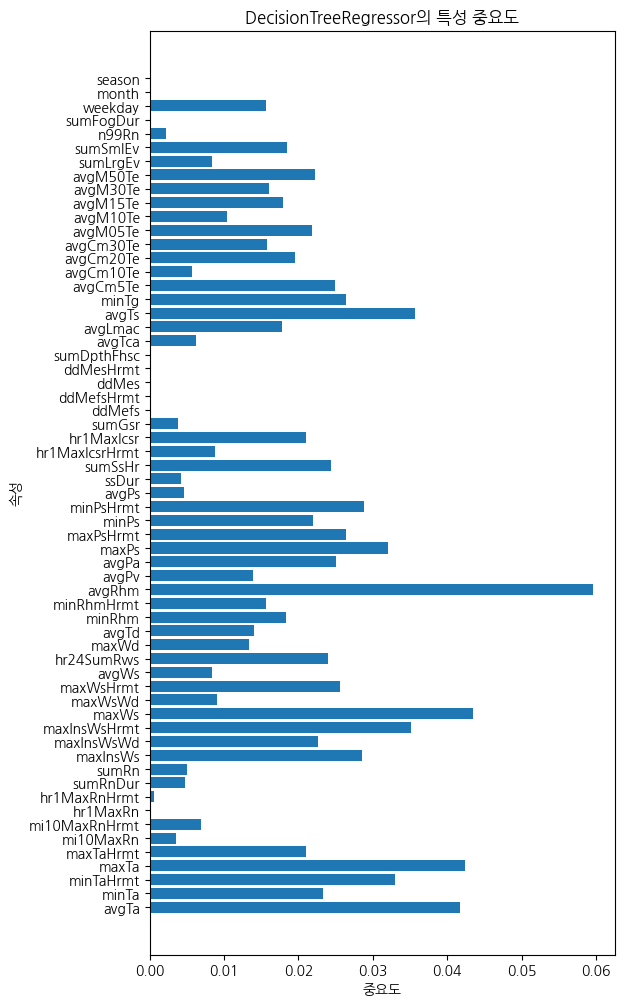

In [24]:
f_importances = model_dtr.feature_importances_

plt.figure(figsize=(6,12))
plt.barh(range(len(f_importances)), f_importances)
plt.yticks(range(len(f_importances)), df_X.columns)
plt.xlabel('중요도')
plt.ylabel('속성')
plt.title('DecisionTreeRegressor의 특성 중요도')
plt.show()

##### Lasso

In [25]:
model_l = Lasso().fit(X_train, y_train)
pred_l = model_l.predict(X_test)
_ = evaluation_func(y_test, pred_l)

R2_SCORE: -0.000064, MAPE2: 53.718882, MSE: 1.162213, RMSE: 1.078060, MAPE: 1739327980028963.500000, MAE: 0.786471


##### Ridge

In [26]:
model_r = Ridge().fit(X_train, y_train)
pred_r = model_r.predict(X_test)
_ = evaluation_func(y_test, pred_r)

R2_SCORE: -0.001309, MAPE2: 58.542024, MSE: 1.163661, RMSE: 1.078731, MAPE: 1713771777975610.000000, MAE: 0.822763


##### GradientBoostingRegressor

In [27]:
model_gbr = GradientBoostingRegressor().fit(X_train, y_train)
pred_gbr = model_gbr.predict(X_test)
_ = evaluation_func(y_test, pred_gbr)

R2_SCORE: -0.062211, MAPE2: 60.348122, MSE: 1.234437, RMSE: 1.111052, MAPE: 1738386497595913.250000, MAE: 0.854063


##### XGBRegressor

In [28]:
model_xgb = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=200,
    n_jobs=-1,
    max_depth=3,
    learning_rate=0.11,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
).fit(X_train, y_train)
pred_xgb = model_xgb.predict(X_test)
_ = evaluation_func(y_test, pred_xgb)

R2_SCORE: -0.120503, MAPE2: 63.997610, MSE: 1.302181, RMSE: 1.141131, MAPE: 1772937323433117.000000, MAE: 0.899810


In [29]:
print(f'Match Count: {np.sum(y_test.to_numpy()==np.round(pred_xgb))}'
      f'/Total Count: {len(pred_xgb)}')

Match Count: 170/Total Count: 548


#### DL

##### CNN
* 다행히 예측해야할 값이 0~6까지의 값으로 클래스와 유사하다.
* 따라서 CNN을 이용해 클래스분류로 회귀가 아닌 방법으로 시도해본다.

In [30]:
df_a.사망자수.value_counts()

사망자수
0    683
1    653
2    339
3    106
4     34
5      6
6      5
Name: count, dtype: int64

In [31]:
EPOCHS = 100
BATCH_SIZE = 32

In [57]:
X_train, X_test, y_train, y_test = \
    train_test_split(df_X, df_y, test_size=0.3, random_state=SEED)

In [58]:
_max_value = X_train.max()
X_train, X_test = X_train/_max_value, X_test/_max_value

In [59]:
X_train, X_test = X_train.values, X_test.values

In [61]:
# 61이 소수라 1*61밖에 안되니 63=9*7로 변경
X_train = np.concatenate([X_train, np.zeros((len(X_train), 2))], axis=1)
X_test = np.concatenate([X_test, np.zeros((len(X_test), 2))], axis=1)

In [62]:
X_train, X_test = X_train.reshape(-1, 9, 7, 1), X_test.reshape(-1, 9, 7, 1)

In [34]:
out_classes = 7

In [35]:
yc_train = tf.keras.utils.to_categorical(y_train, num_classes=out_classes)
yc_test = tf.keras.utils.to_categorical(y_test, num_classes=out_classes)

In [69]:
model_cnn = tf.keras.Sequential([
    Conv2D(32, kernel_size=3, activation='relu', input_shape=(9,7,1)),
    # MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=3, activation='relu'),
    # MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=3, activation='relu'),
    # MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(out_classes, activation='softmax')
])

In [70]:
model_cnn.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [71]:
model_cnn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 7, 5, 32)          320       
                                                                 
 conv2d_26 (Conv2D)          (None, 5, 3, 64)          18496     
                                                                 
 conv2d_27 (Conv2D)          (None, 3, 1, 128)         73856     
                                                                 
 flatten_9 (Flatten)         (None, 384)               0         
                                                                 
 dense_19 (Dense)            (None, 128)               49280     
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 dense_21 (Dense)            (None, 7)                

In [72]:
history = model_cnn.fit(
    X_train, y_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2
)

Epoch 1/100


32/32 [==============================] - 2s 10ms/step - loss: 1.4675 - accuracy: 0.3591 - val_loss: 1.2973 - val_accuracy: 0.4141
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 1.3476 - accuracy: 0.3523 - val_loss: 1.2663 - val_accuracy: 0.3633
Epoch 3/100
32/32 [==============================] - 0s 4ms/step - loss: 1.3340 - accuracy: 0.3796 - val_loss: 1.3051 - val_accuracy: 0.4141
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 1.3442 - accuracy: 0.3552 - val_loss: 1.2943 - val_accuracy: 0.3672
Epoch 5/100
32/32 [==============================] - 0s 4ms/step - loss: 1.3391 - accuracy: 0.3689 - val_loss: 1.2779 - val_accuracy: 0.3633
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 1.3365 - accuracy: 0.3708 - val_loss: 1.2853 - val_accuracy: 0.3398
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 1.3390 - accuracy: 0.3679 - val_loss: 1.2788 - val_accuracy: 0.4141
Epoch 8/100
32/32 [=====

In [73]:
_test_loss, _test_accuracy = model_cnn.evaluate(X_test, y_test, verbose=2)
print(f'Test loss: {_test_loss:.05f}, accuracy: {_test_accuracy:.05f}')

18/18 - 0s - loss: 6.6915 - accuracy: 0.3157 - 183ms/epoch - 10ms/step
Test loss: 6.69147, accuracy: 0.31569
